In [1]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import matplotlib.patches as patches
import torch
import copy
import sys
sys.path.append("/Users/LOCCO_Louise/Documents/Git/code_amaury")
from simu_PSF_polarMFM import *
from extract_experimental_psf import *
from tqdm import tqdm
import time
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU")
else:   
    device = torch.device('cpu')
    print("Using CPU")

Using GPU


In [3]:
d = np.array([5, 5, 5])
d = np.array([np.mean(d)-0.350, np.mean(d), np.mean(d)+0.350])
QE = 0.92
EM = 100
sensitivity = 15.4

In [4]:
Nframe=15

In [5]:
raw = np.zeros((Nframe,6,214,129))

In [6]:
path_info = 'C:\\Users\\Amaury\\Desktop\\cell005midS\\cell005_polar_1_results_fr1to60000_method=Propagationmatrix_box-method=Fixed_box5.csv'

In [7]:
def extract_frames(frame_0, N_frame):
    error_indices = []
    for i in range(N_frame):
        number = str(frame_0 + i).zfill(5)
        print(number)
        path_data = 'C:\\Users\\Amaury\\Desktop\\cell005midS\\cell005_polar_1_reco_concat\\cell005_polar_1_'+number+'.tif'
        raw_ = extract_raw(path_data)
        if raw_ is None:
            error_indices.append(i)
            continue
        else:
            raw[i] = raw_
        del(raw_)
    return raw, error_indices

def extract_positions(frame_0, N_frame, error_indices):
    index_frame = []
    x, y, z, rho, delta = [], [], [], [], []
    ind = 0
    for i in range(N_frame):
        if i not in error_indices:
            x__, y__, z__, rho__, delta__ = position_from_data(data, frame_0+i)
            x = np.concatenate((x, x__))
            y = np.concatenate((y, y__))
            z = np.concatenate((z, z__))
            rho = np.concatenate((rho, rho__))
            delta = np.concatenate((delta, delta__))
            for k in range(len(x__)):
                index_frame.append(ind)
        ind+=1
    index_frame=np.array(index_frame)
    return x, y, z, rho, delta, index_frame

def limit(x, lim, slope, upper=True):
    '''
    if upper:
       return torch.sum(torch.tensor(1/(1+torch.exp(-slope*(x-lim))), requires_grad=True, device=device))
    else:
        return torch.sum(torch.tensor(1/(1+torch.exp(slope*(x-lim))), requires_grad=True, device=device))
    '''
    if upper:
        return torch.sum(torch.exp((x-lim)*slope))
    else:
        return torch.sum(torch.exp(-1*(x-lim)*slope))
    
def loss_pos(xp, yp, zp, rho, eta, delta, N_photons, data, second_plane, background, sigma, dim_simu):
    u, v, M_ = compute_M(xp=xp, yp=yp, zp=zp, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, phase_maskx=phase_mask, phase_masky=phase_mask, zernike_base=zernike_base, zernike_coefs_x=zernike_coefs_x, zernike_coefs_y=zernike_coefs_x,
                        second_plane=second_plane, polar_projections=polar_projections, N=N,
                    l_pixel=l_pixel, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device, polar_offset=0., polar_offset2=0.)
    dim_data = 6
    h = PSF(rho=rho, eta=eta, delta=delta, M=M_, N_photons=N_photons)[:,:,:,dim_simu-dim_data:dim_simu+dim_data+1,dim_simu-dim_data:dim_simu+dim_data+1]
    loss = torch.sum(torch.add(h, -(data+sigma**2)*torch.log(h+background+sigma**2)))
    #loss = torch.sum(torch.pow(torch.sum(torch.add(h, -data), dim=(2,)), 2)) 
    x_bound = limit(xp, 5*0.12, 100, upper=True) + limit(xp, -5*0.12, 100, upper=False)
    y_bound = limit(yp, 5*0.12, 100, upper=True) + limit(yp, -5*0.12, 100, upper=False)
    z_bound = limit(zp, 5., 100, upper=True) + limit(zp, 0, 100, upper=False)
    N_bound = limit(N_photons, 10000., 0.01, upper=True)
    return loss +x_bound+y_bound+z_bound#+N_bound

def loss_angle(M_, rho, eta, delta, N_photons, data, background, sigma, dim_simu):
    dim_data = 6
    h = PSF(rho=rho, eta=eta, delta=delta, M=M_, N_photons=N_photons)[:,:,:,dim_simu-dim_data:dim_simu+dim_data+1,dim_simu-dim_data:dim_simu+dim_data+1]

    loss = torch.sum(torch.add(h, -(data+sigma**2)*torch.log(h+background+sigma**2)))
    #loss = torch.sum(torch.pow(torch.sum(torch.add(h, -data), dim=(2,)), 2)) 
    delta_bound = limit(delta, 180, 100, upper=True) + limit(delta, 1, 100, upper=False)
    N_bound = limit(N_photons, 10000., 0.01, upper=True)
    return loss + 1000.*(delta_bound)# + N_bound) #+ 100000*torch.sum(h**2)

def loss_angle_with_M(polar_proj, polar_proj2, rho, eta, delta, N_photons, data, background, sigma, dim_simu):
    dim_data = 6
    u, v, M_ = compute_M(xp=x_found, yp=y_found, zp=z_found, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, phase_masky=phase_mask, phase_maskx=phase_mask, zernike_base=zernike_base, zernike_coefs_x=zernike_coefs_x, zernike_coefs_y=zernike_coefs_x,
                        second_plane=second_plane, polar_projections=polar_projections, N=N,
                    l_pixel=l_pixel, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device, polar_offset=polar_proj, polar_offset2=polar_proj2)
    h = PSF(rho=rho, eta=eta, delta=delta, M=M_, N_photons=N_photons)[:,:,:,dim_simu-dim_data:dim_simu+dim_data+1,dim_simu-dim_data:dim_simu+dim_data+1]
    
    loss = torch.sum(torch.add(h, -(data+sigma**2)*torch.log(h+background+sigma**2)))
    #loss = torch.sum(torch.pow(torch.sum(torch.add(h, -data), dim=(2,)), 2)) 
    delta_bound = limit(delta, 180, 100, upper=True) + limit(delta, 1, 100, upper=False)
    N_bound = limit(N_photons, 10000., 0.01, upper=True)
    return loss + 1000.*(delta_bound)# + N_bound) #+ 100000*torch.sum(h**2)

def score_eval(M_, rho, eta, delta, N_photons, data, background, sigma, dim_simu):
    dim_data = 6
    h = PSF(rho=rho, eta=eta, delta=delta, M=M_, N_photons=N_photons)[:,:,:,dim_simu-dim_data:dim_simu+dim_data+1,dim_simu-dim_data:dim_simu+dim_data+1]
    score = torch.sum(torch.add(h, -(data+sigma**2)*torch.log(h+background+sigma**2)), dim=(1,2,3,4))
    return score.numpy() 

In [8]:
data = pos_from_csv(path_info)

In [9]:
N_batch = 350 

In [10]:
batch_offset = 0

In [11]:
offset_count = 14.1
print(offset_count)

14.1


00001
00002
00003
00004
00005
00006
00007
00008
00009
00010
00011
00012
00013
00014
00015


C:\Users\Amaury\AppData\Local\Temp\ipykernel_24936\1448085547.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  noisy_psf = torch.tensor([single_psf[k] for k in range(len(x))], device=device)
C:\Users\Amaury\anaconda3\envs\amaury_gpu\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


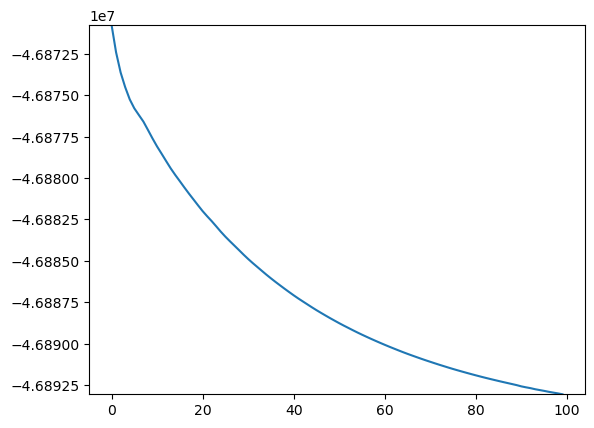

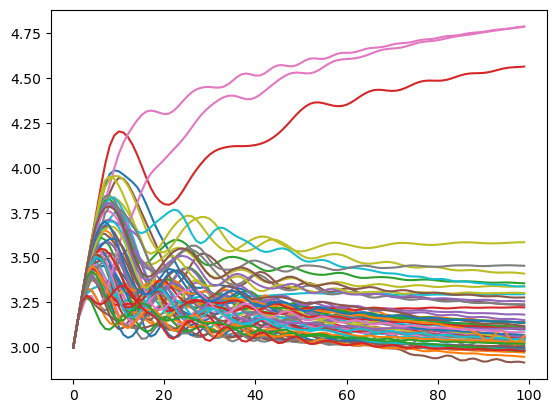

NPSF =  66


100%|██████████| 220/220 [02:35<00:00,  1.41it/s]


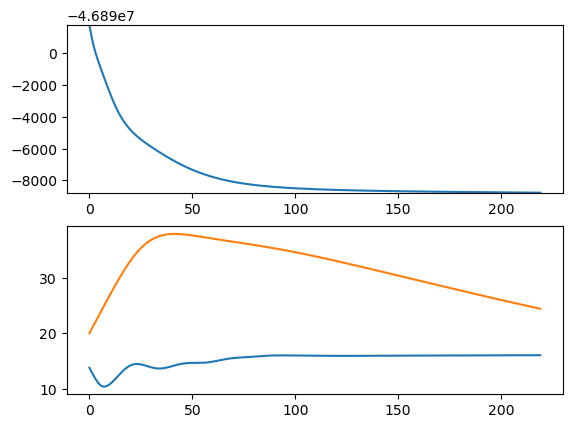

00016
00017
00018
00019
00020
00021
00022
00023
00024
00025
00026
00027
00028
00029
00030


100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


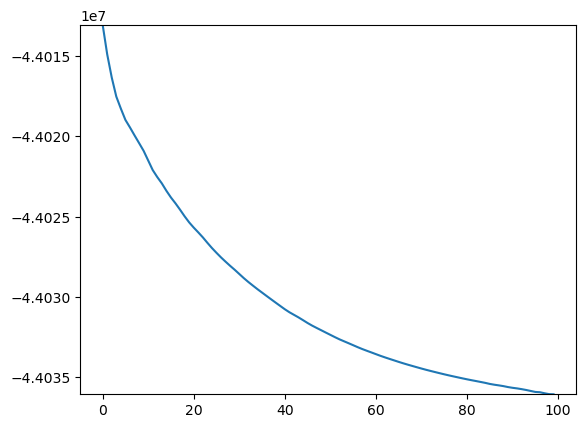

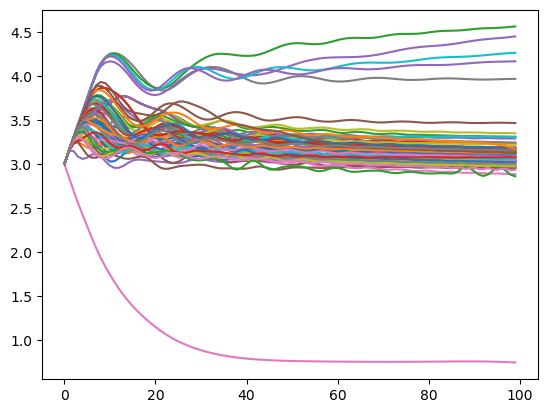

NPSF =  68


100%|██████████| 220/220 [02:37<00:00,  1.40it/s]


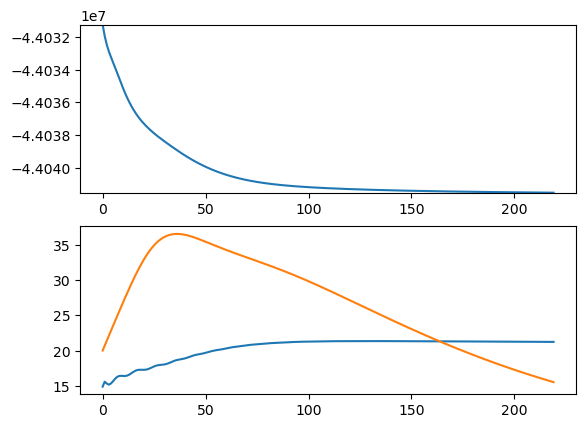

00031
00032
00033
00034
00035
00036
00037
00038
00039
00040
00041
00042
00043
00044
00045


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


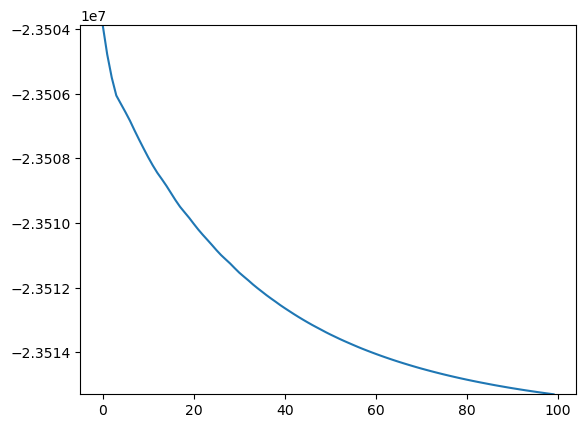

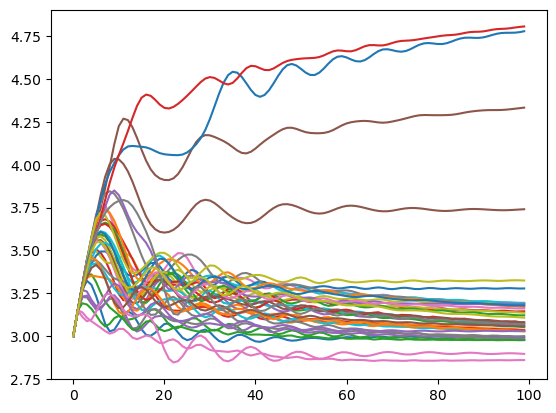

NPSF =  39


100%|██████████| 220/220 [02:08<00:00,  1.71it/s]


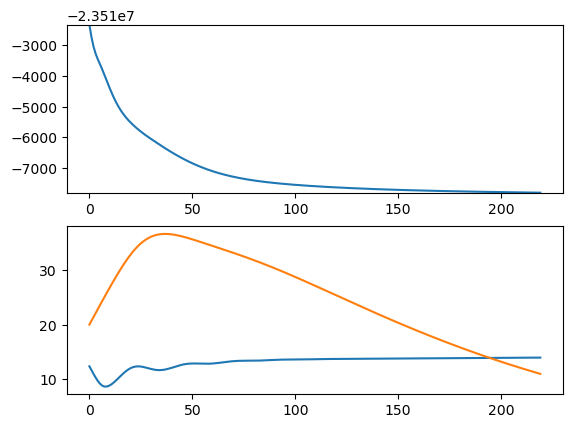

00046
00047
00048
00049
00050
00051
00052
00053
00054
00055
00056
00057
00058
00059
00060


100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


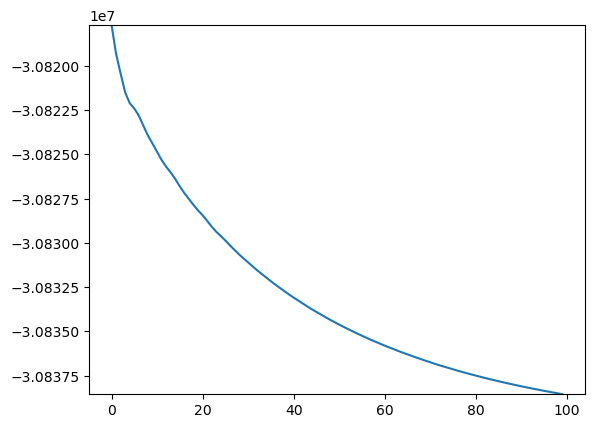

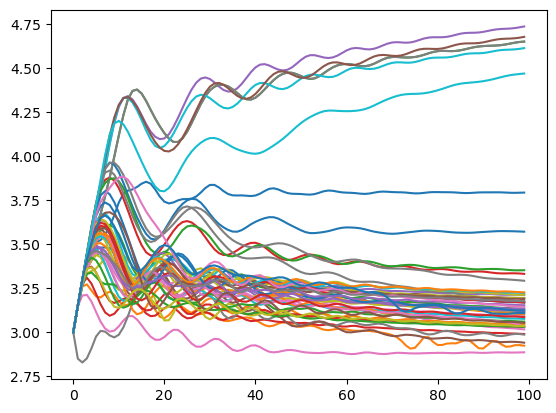

NPSF =  51


100%|██████████| 220/220 [02:20<00:00,  1.57it/s]


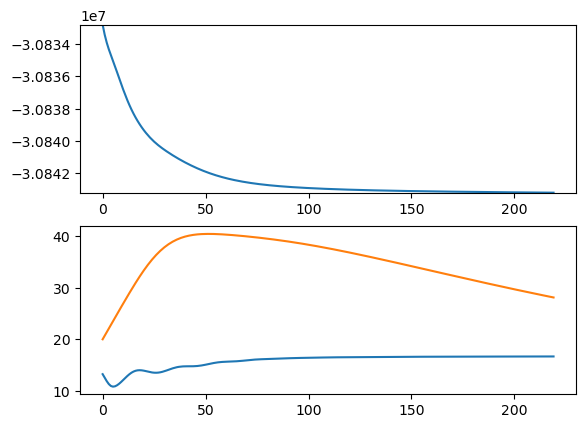

00061
00062
00063
00064
00065
00066
00067
00068
00069
00070
00071
00072
00073
00074
00075


100%|██████████| 100/100 [00:12<00:00,  7.91it/s]


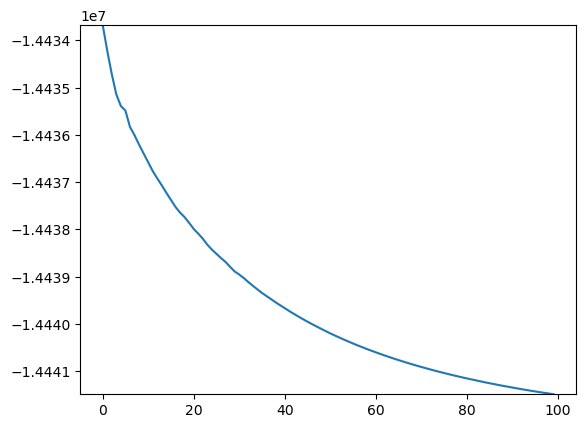

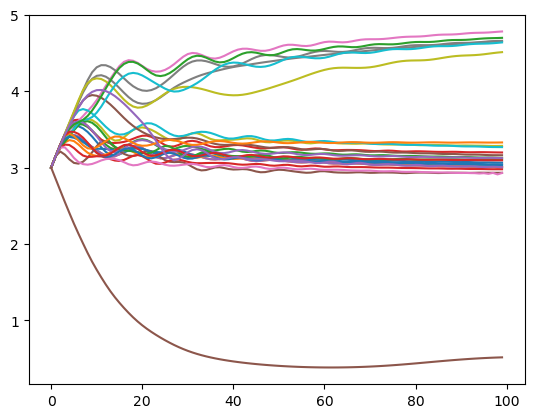

NPSF =  26


100%|██████████| 220/220 [01:55<00:00,  1.91it/s]


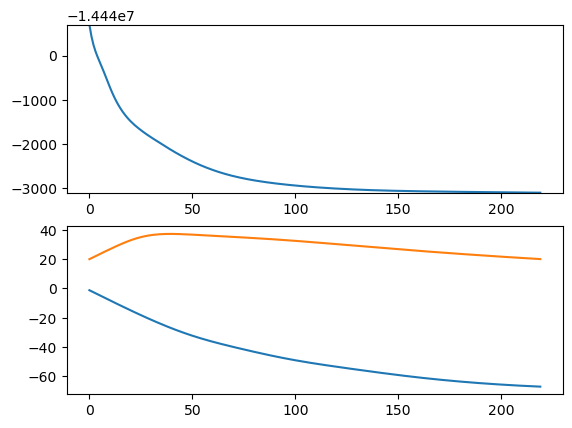

00076
00077
00078
00079
00080
00081
00082
00083
00084
00085
00086
00087
00088
00089
00090


100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


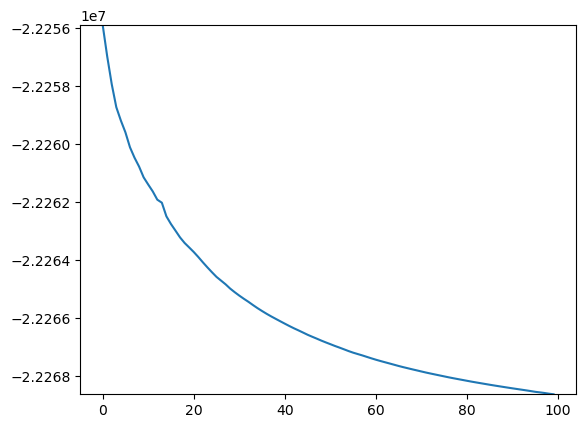

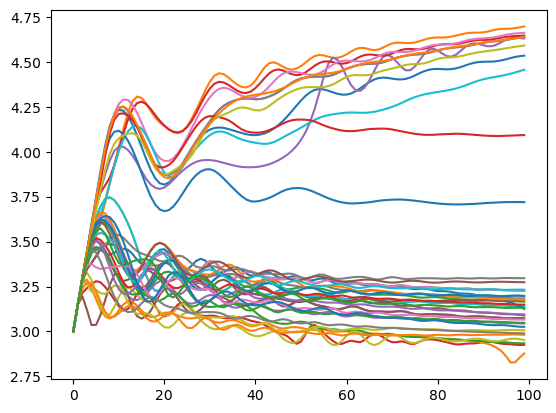

NPSF =  43


100%|██████████| 220/220 [02:12<00:00,  1.66it/s]


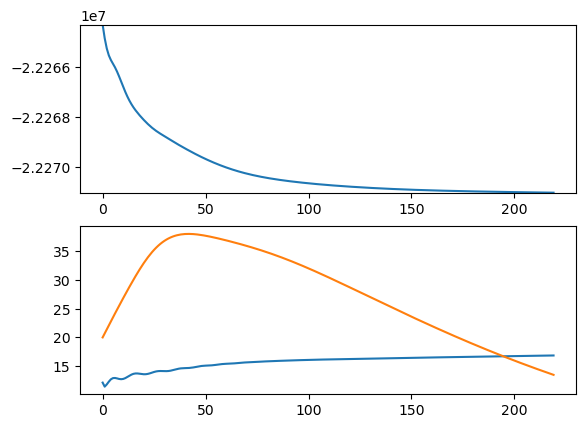

00091
00092
00093
00094
00095
00096
00097
00098
00099
00100
00101
00102
00103
00104
00105


100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


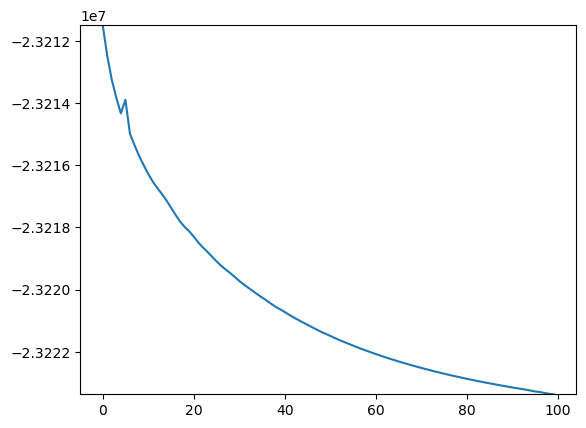

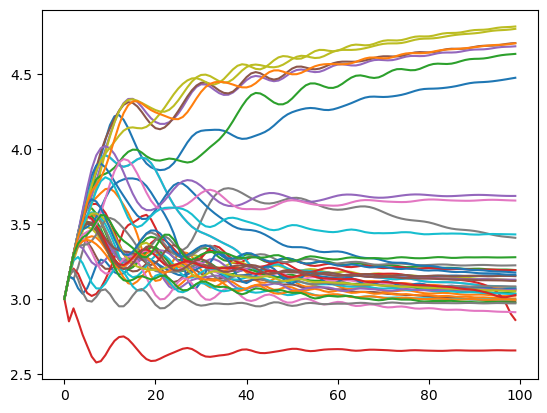

NPSF =  43


100%|██████████| 220/220 [02:12<00:00,  1.66it/s]


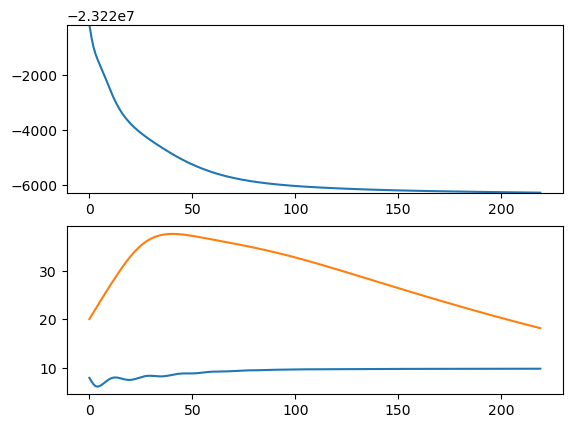

00106
00107
00108
00109
00110
00111
00112
00113
00114
00115
00116
00117
00118
00119
00120


100%|██████████| 100/100 [00:21<00:00,  4.59it/s]


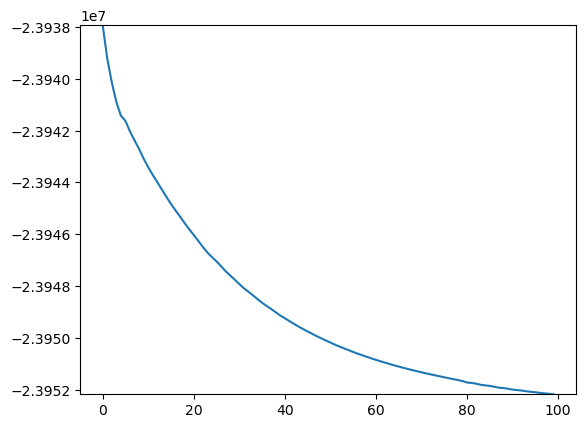

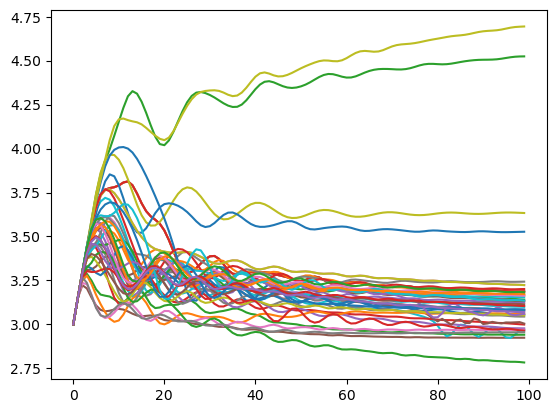

NPSF =  45


100%|██████████| 220/220 [02:14<00:00,  1.63it/s]


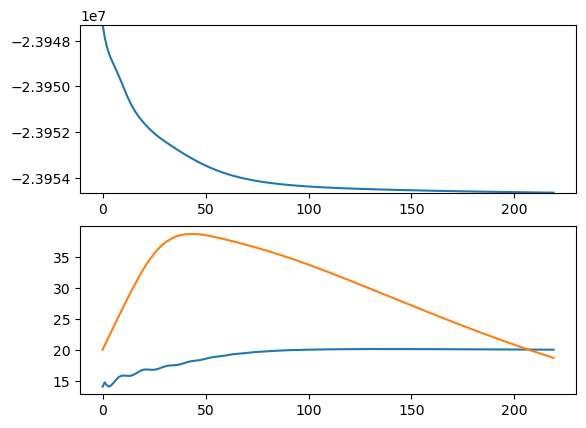

00121
00122
00123
00124
00125
00126
00127
00128
00129
00130
00131
00132
00133
00134
00135


100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


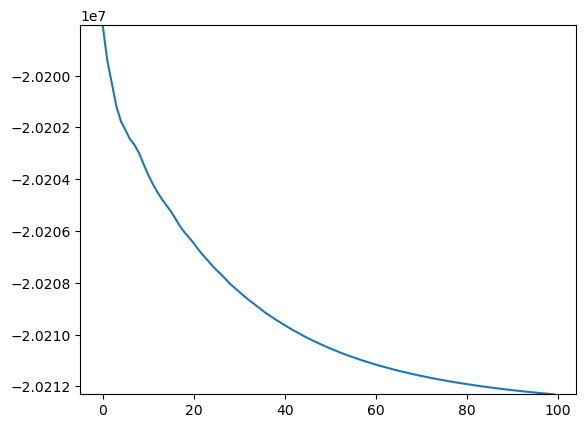

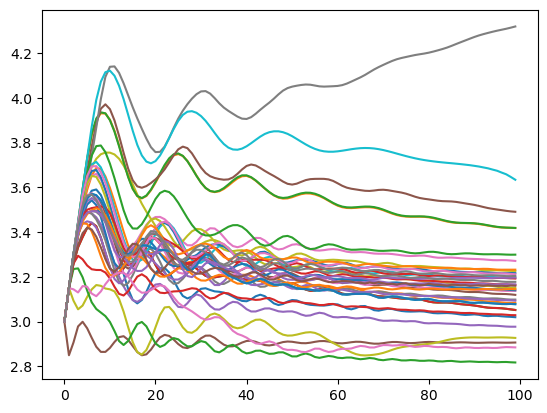

NPSF =  38


100%|██████████| 220/220 [02:07<00:00,  1.73it/s]


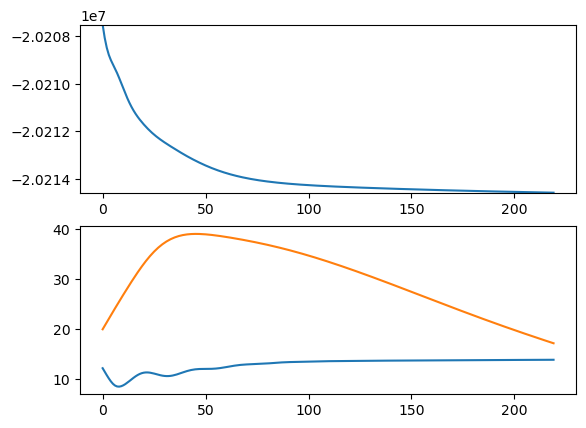

00136
00137
00138
00139
00140
00141
00142
00143
00144
00145
00146
00147
00148
00149
00150


100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


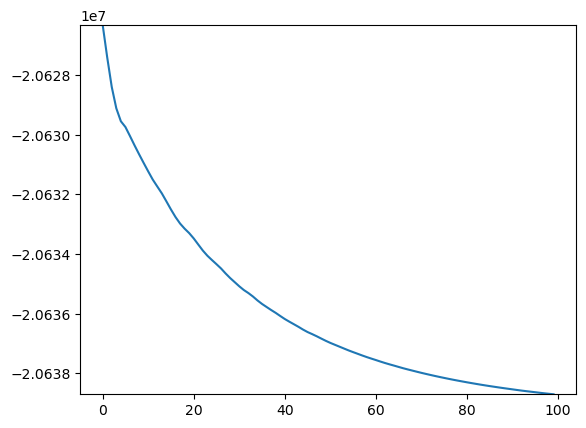

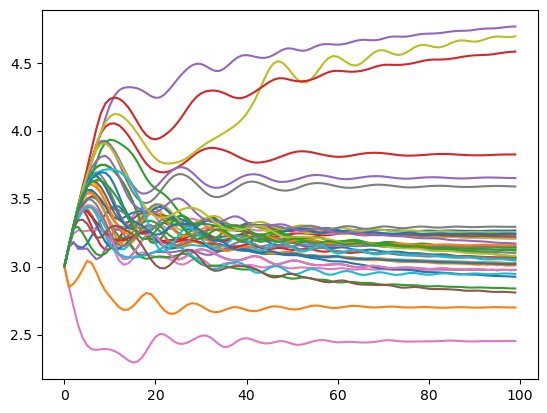

NPSF =  43


100%|██████████| 220/220 [02:12<00:00,  1.66it/s]


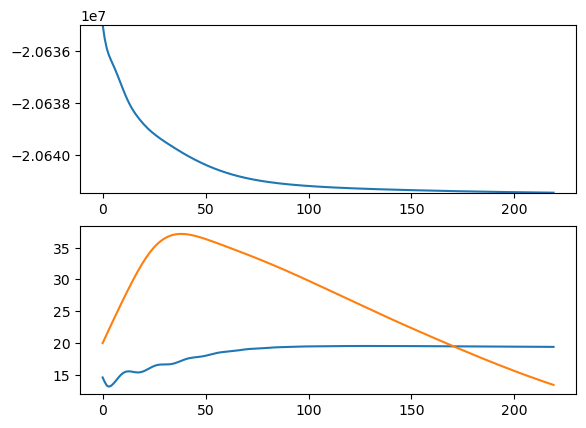

00151
00152
00153
00154
00155
00156
00157
00158
00159
00160
00161
00162
00163
00164
00165


100%|██████████| 100/100 [00:11<00:00,  8.85it/s]


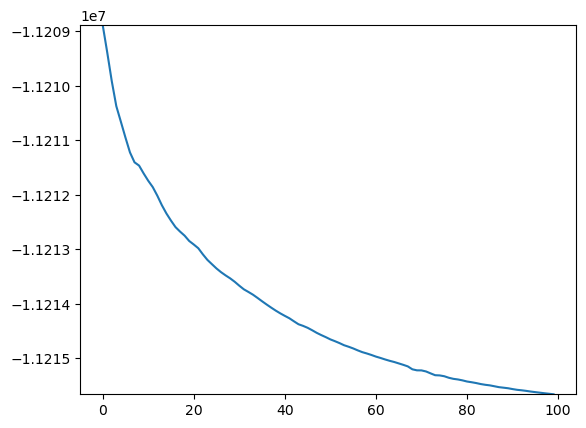

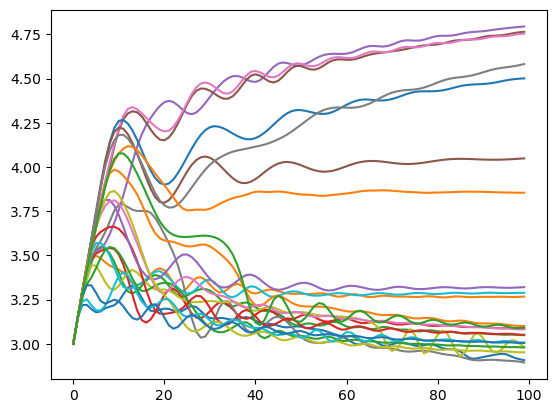

NPSF =  23


100%|██████████| 220/220 [01:52<00:00,  1.96it/s]


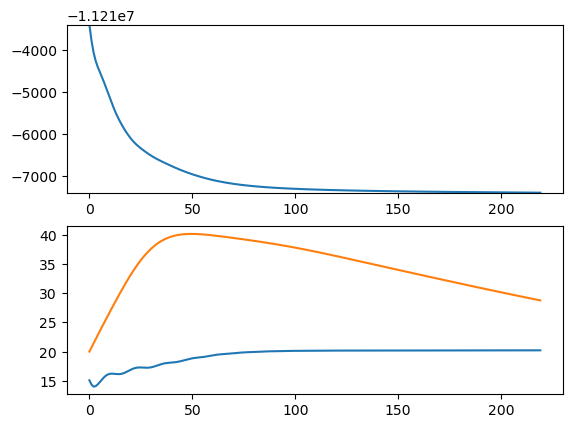

00166
00167
00168
00169
00170
00171
00172
00173
00174
00175
00176
00177
00178
00179
00180


100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


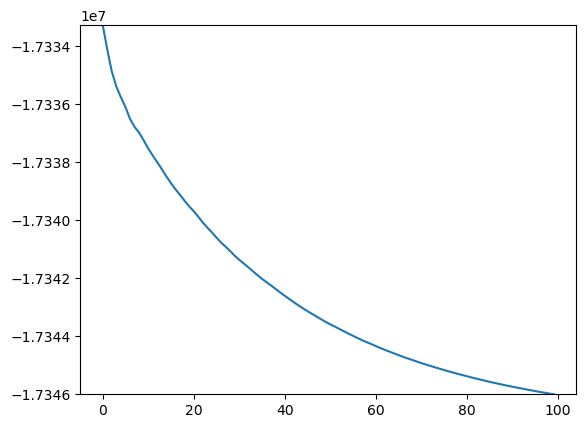

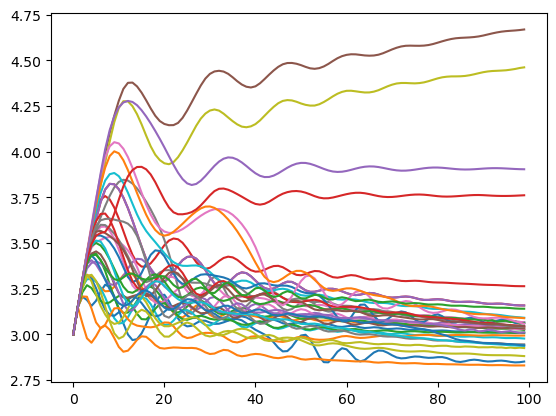

NPSF =  35


100%|██████████| 220/220 [02:04<00:00,  1.77it/s]


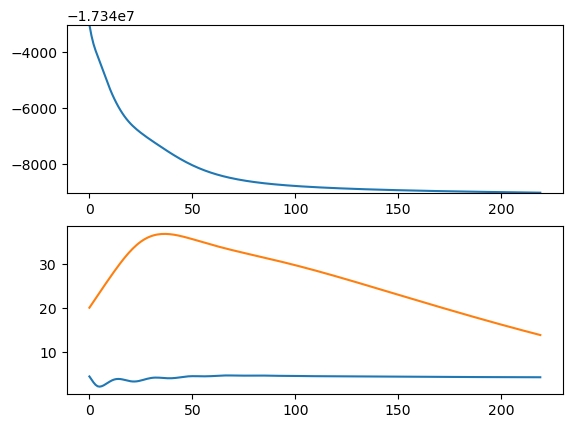

00181
00182
00183
00184
00185
00186
00187
00188
00189
00190
00191
00192
00193
00194
00195


100%|██████████| 100/100 [00:11<00:00,  8.95it/s]


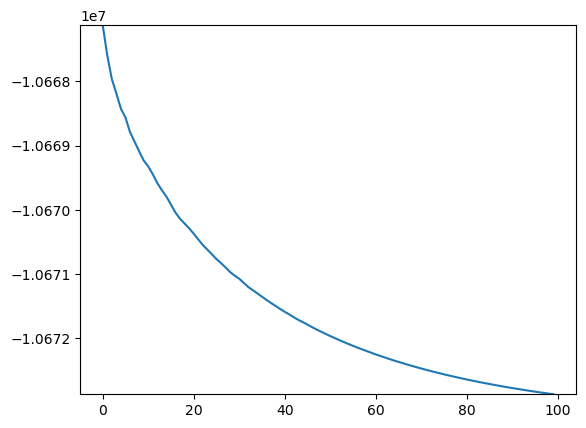

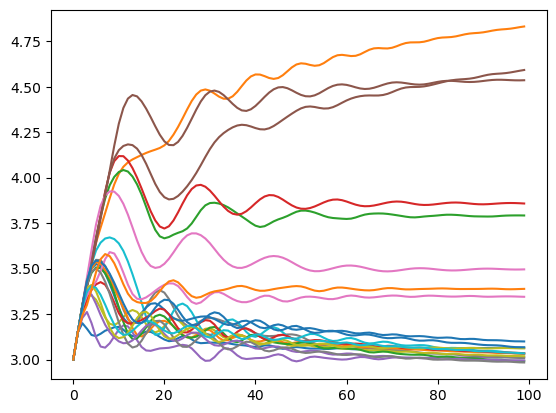

NPSF =  22


100%|██████████| 220/220 [01:50<00:00,  1.98it/s]


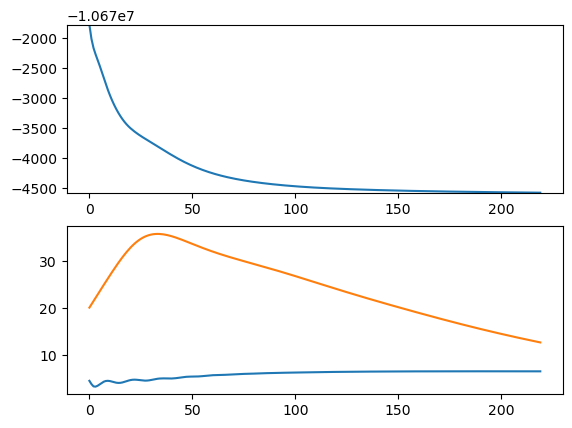

00196
00197
00198
00199
00200
00201
00202
00203
00204
00205
00206
00207
00208
00209
00210


100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


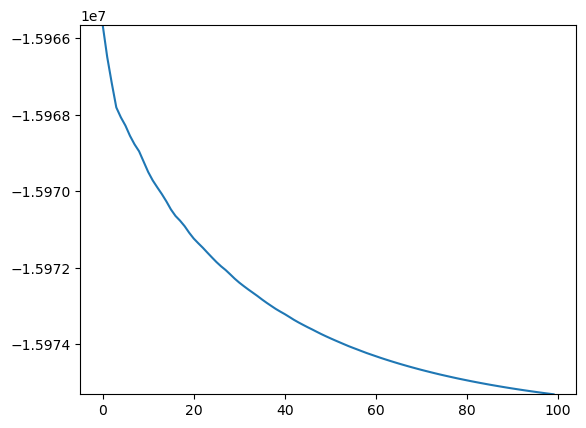

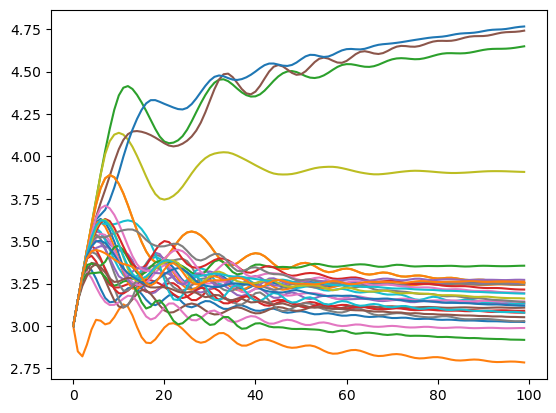

NPSF =  32


100%|██████████| 220/220 [02:01<00:00,  1.81it/s]


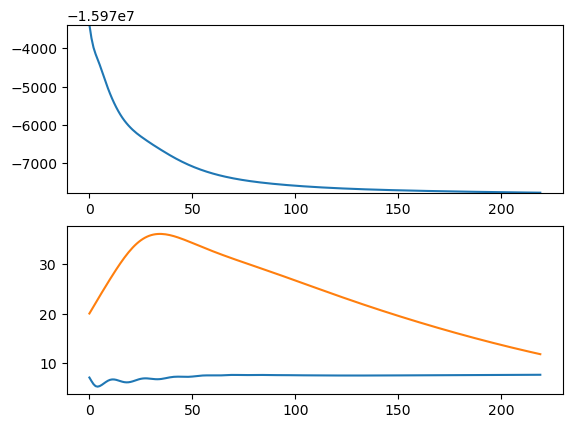

00211
00212
00213
00214
00215
00216
00217
00218
00219
00220
00221
00222
00223
00224
00225


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


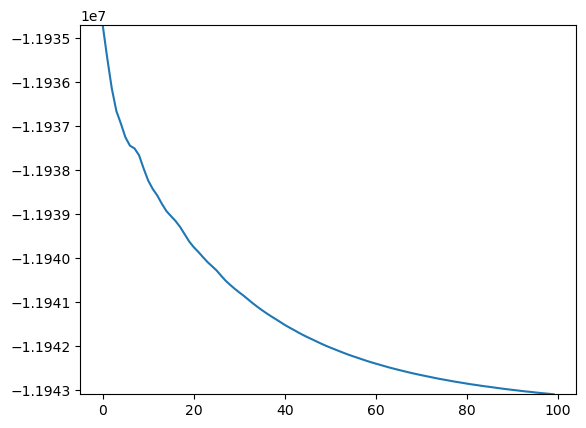

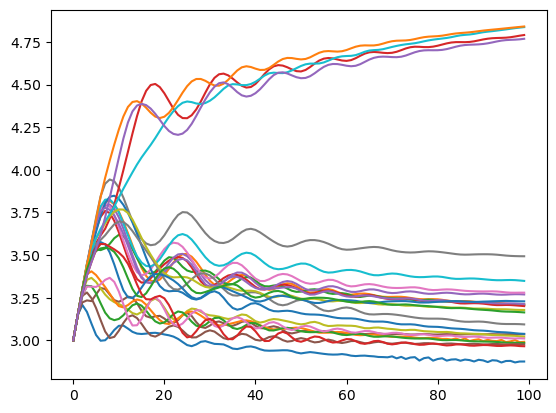

NPSF =  25


100%|██████████| 220/220 [01:53<00:00,  1.93it/s]


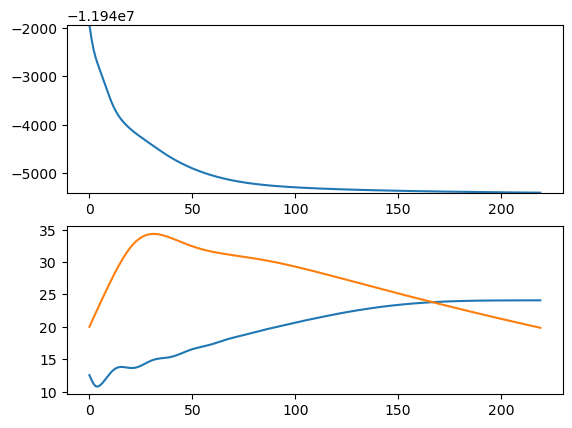

00226
00227
00228
00229
00230
00231
00232
00233
00234
00235
00236
00237
00238
00239
00240


100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


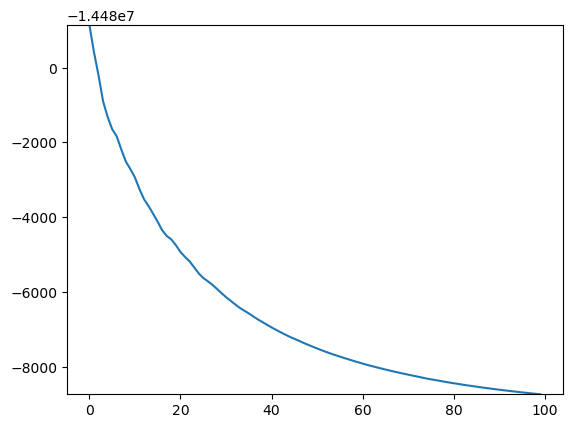

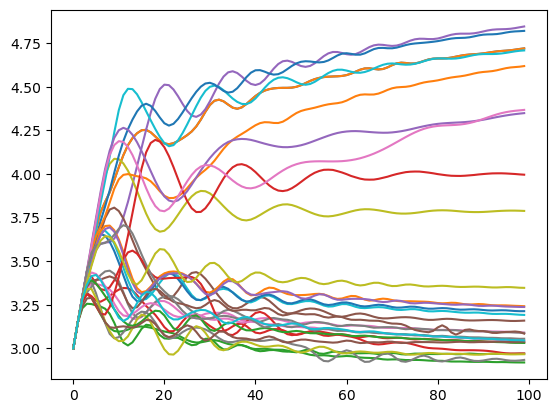

NPSF =  30


100%|██████████| 220/220 [01:59<00:00,  1.84it/s]


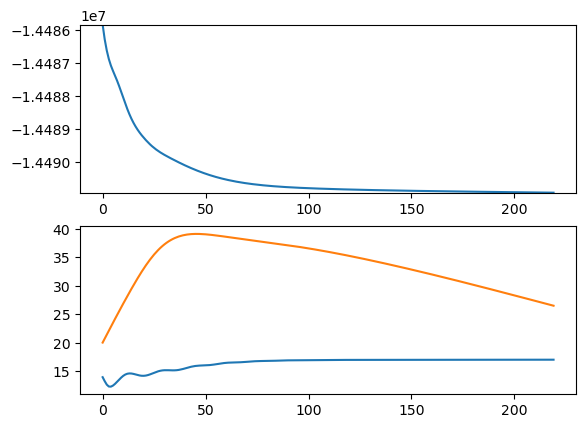

00241
00242
00243
00244
00245
00246
00247
00248
00249
00250
00251
00252
00253
00254
00255


100%|██████████| 100/100 [00:09<00:00, 10.65it/s]


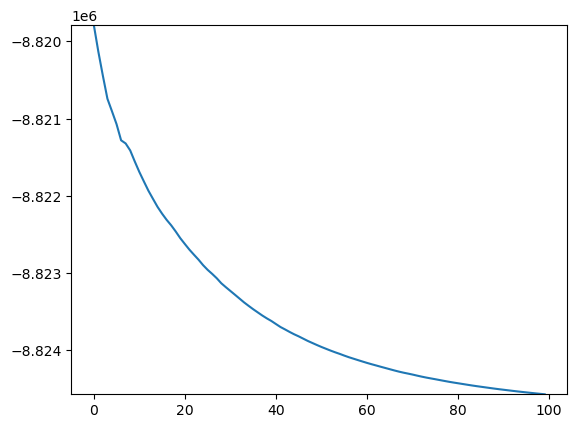

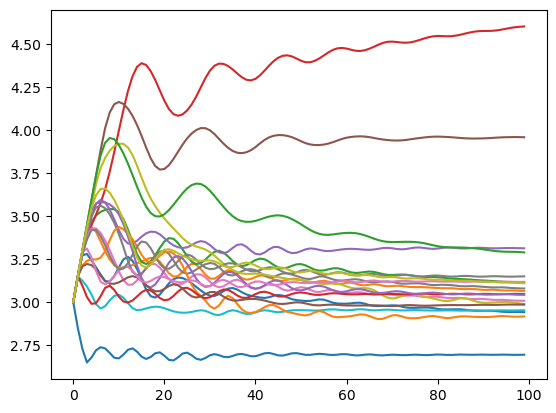

NPSF =  19


100%|██████████| 220/220 [01:48<00:00,  2.03it/s]


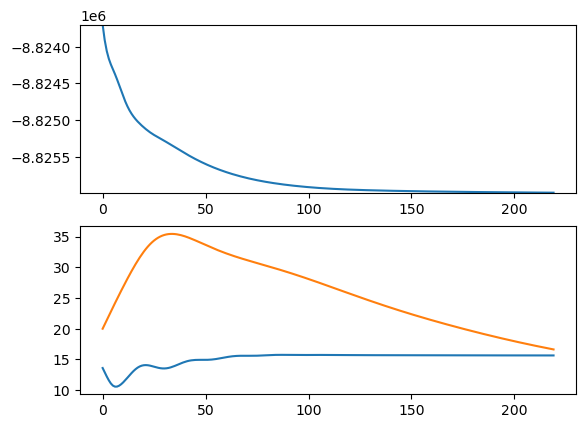

00256
00257
00258
00259
00260
00261
00262
00263
00264
00265
00266
00267
00268
00269
00270


100%|██████████| 100/100 [00:08<00:00, 11.78it/s]


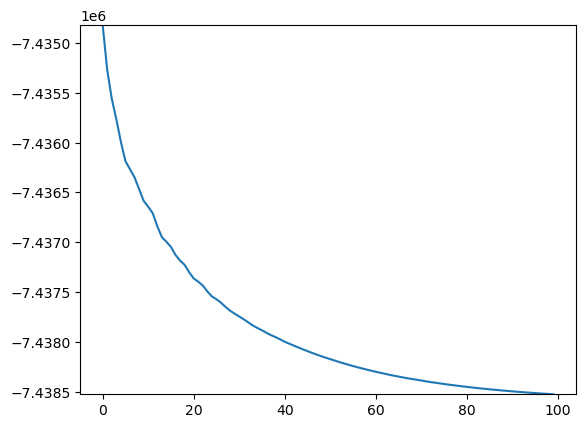

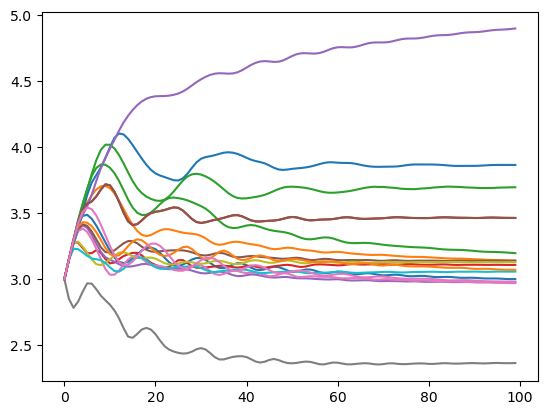

NPSF =  17


100%|██████████| 220/220 [01:46<00:00,  2.07it/s]


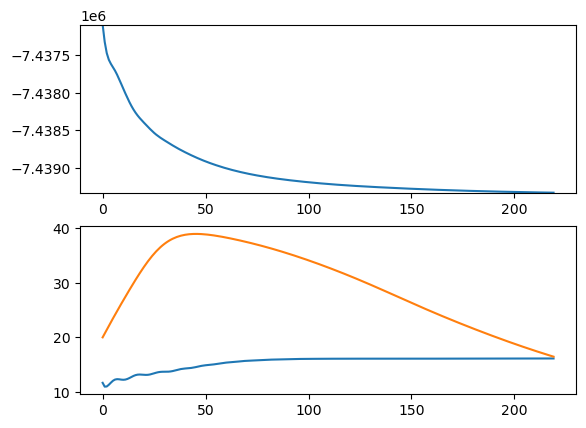

00271
00272
00273
00274
00275
00276
00277
00278
00279
00280
00281
00282
00283
00284
00285


100%|██████████| 100/100 [00:11<00:00,  8.91it/s]


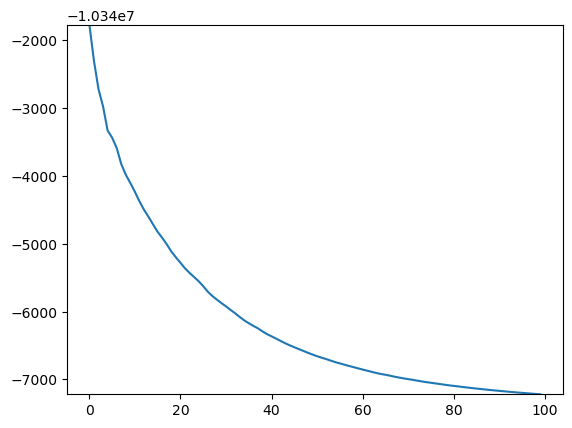

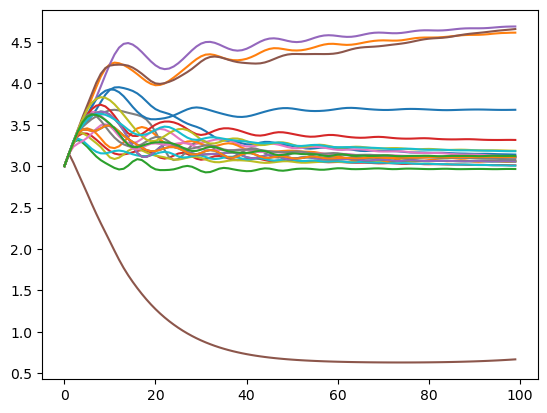

NPSF =  23


100%|██████████| 220/220 [01:51<00:00,  1.96it/s]


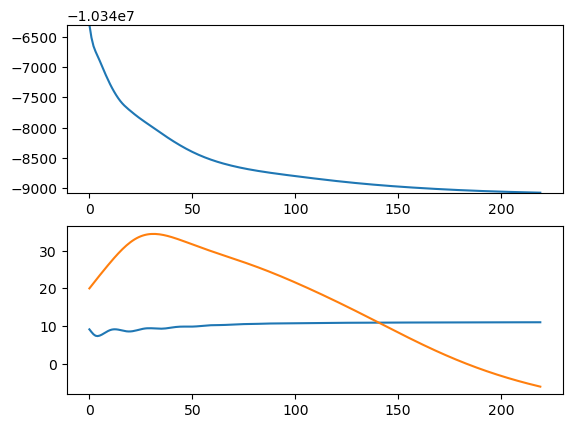

00286
00287
00288
00289
00290
00291
00292
00293
00294
00295
00296
00297
00298
00299
00300


100%|██████████| 100/100 [00:09<00:00, 10.67it/s]


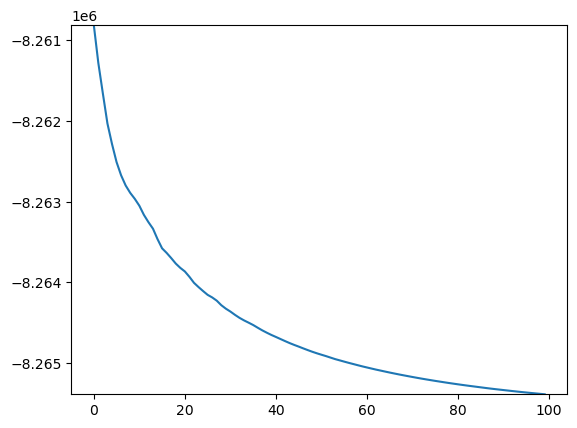

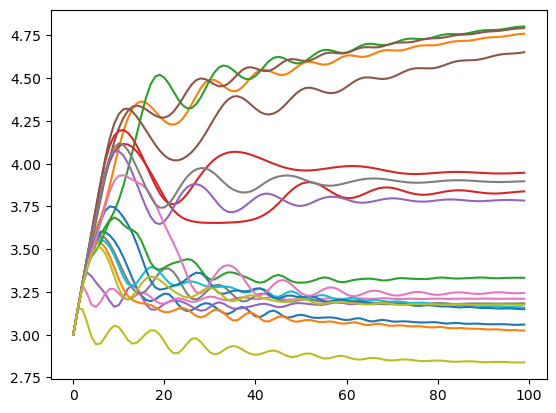

NPSF =  19


100%|██████████| 220/220 [01:48<00:00,  2.03it/s]


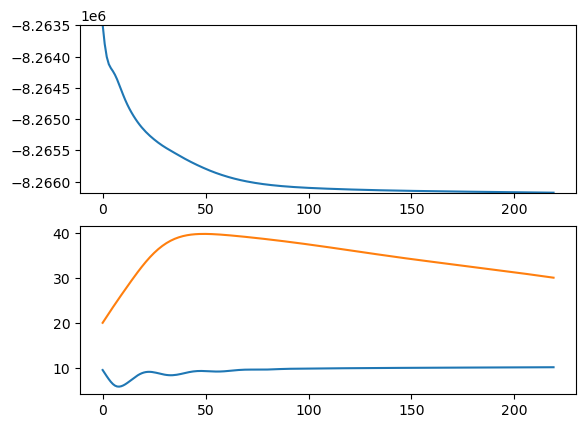

00301
00302
00303
00304
00305
00306
00307
00308
00309
00310
00311
00312
00313
00314
00315


100%|██████████| 100/100 [00:05<00:00, 17.33it/s]


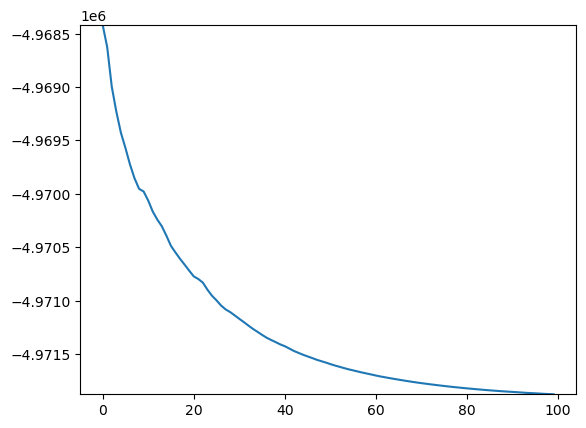

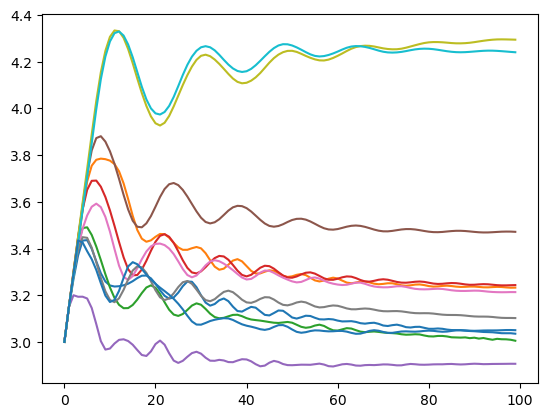

NPSF =  11


100%|██████████| 220/220 [01:40<00:00,  2.19it/s]


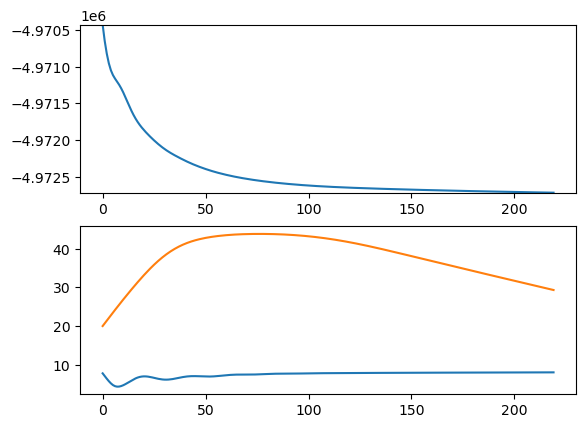

00316
00317
00318
00319
00320
00321
00322
00323
00324
00325
00326
00327
00328
00329
00330


100%|██████████| 100/100 [00:13<00:00,  7.39it/s]


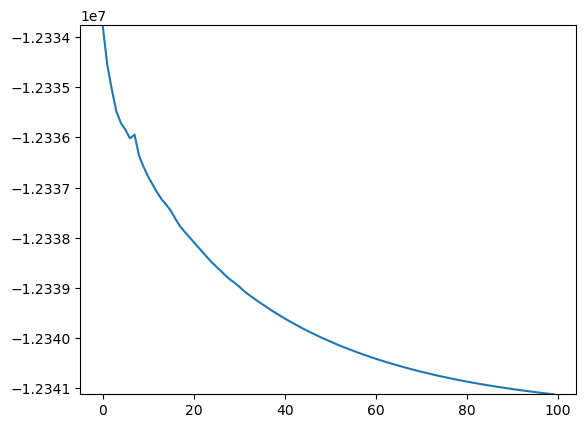

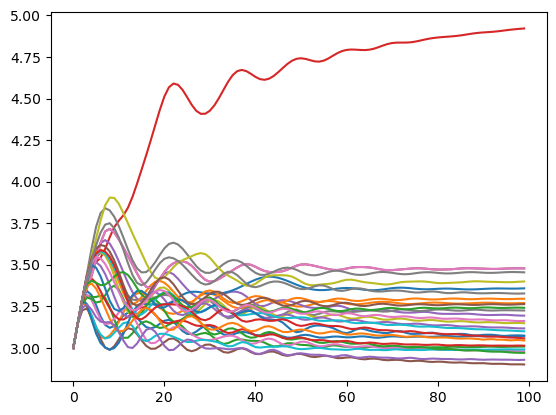

NPSF =  28


100%|██████████| 220/220 [01:57<00:00,  1.88it/s]


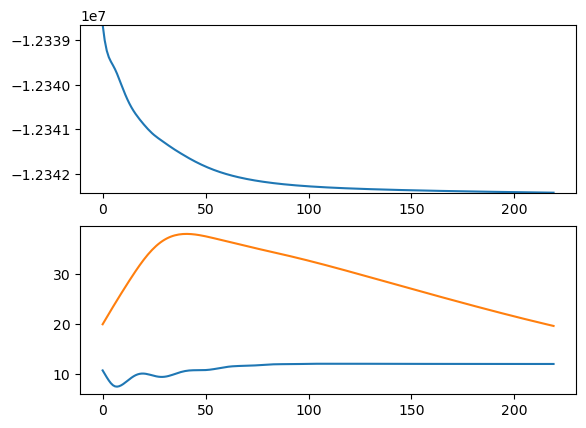

00331
00332
00333
00334
00335
00336
00337
00338
00339
00340
00341
00342
00343
00344
00345


100%|██████████| 100/100 [00:13<00:00,  7.64it/s]


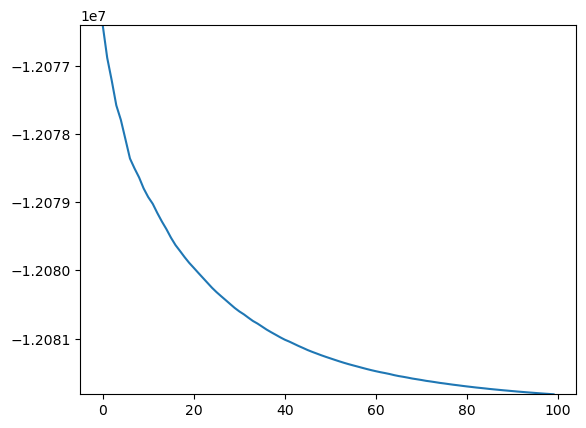

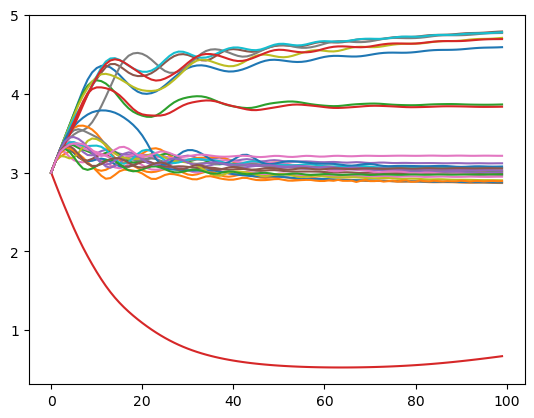

NPSF =  27


100%|██████████| 220/220 [01:56<00:00,  1.90it/s]


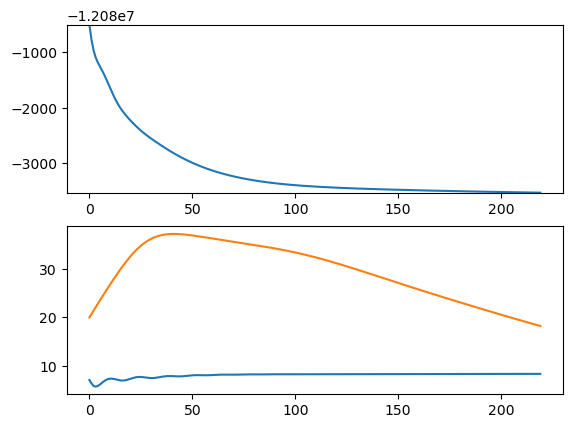

00346
00347
00348
00349
00350
00351
00352
00353
00354
00355
00356
00357
00358
00359
00360


100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


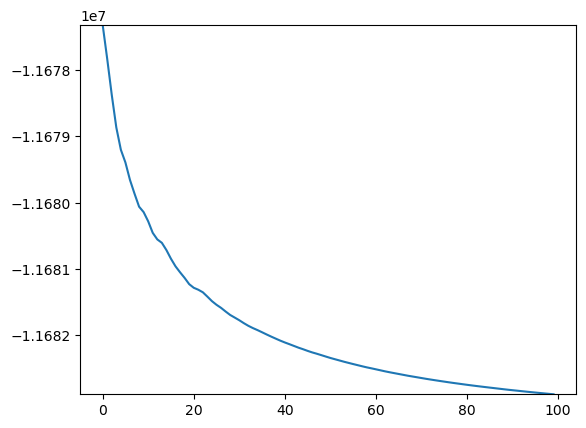

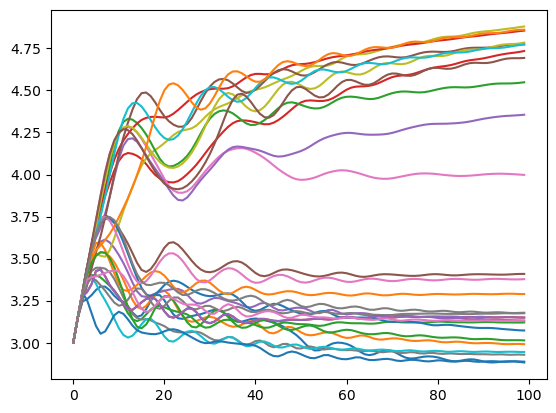

NPSF =  28


100%|██████████| 220/220 [01:56<00:00,  1.88it/s]


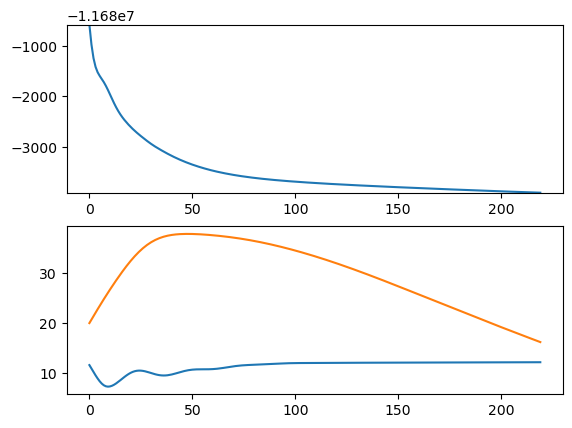

00361
00362
00363
00364
00365
00366
00367
00368
00369
00370
00371
00372
00373
00374
00375


100%|██████████| 100/100 [00:09<00:00, 10.22it/s]


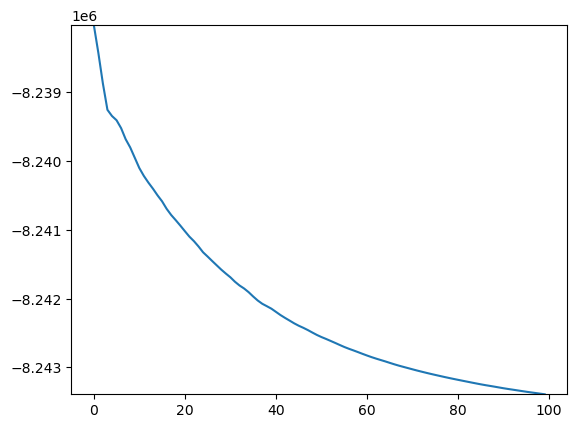

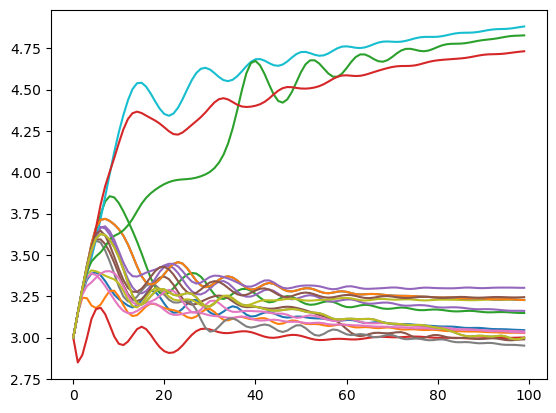

NPSF =  19


100%|██████████| 220/220 [01:47<00:00,  2.04it/s]


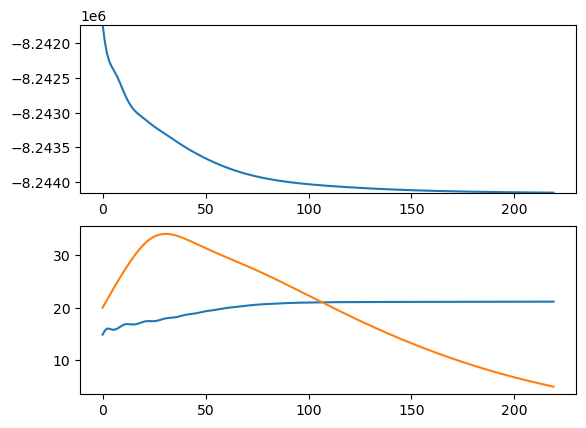

00376
00377
00378
00379
00380
00381
00382
00383
00384
00385
00386
00387
00388
00389
00390


100%|██████████| 100/100 [00:13<00:00,  7.67it/s]


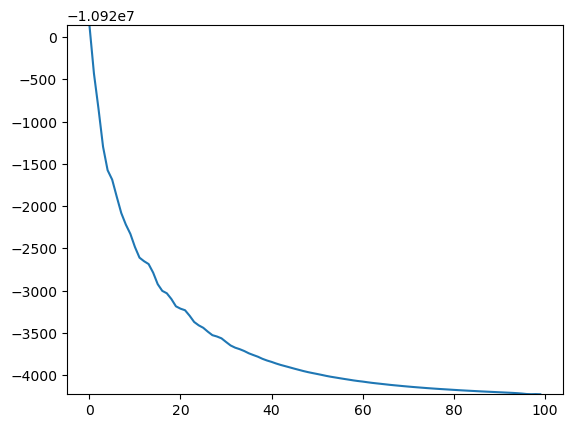

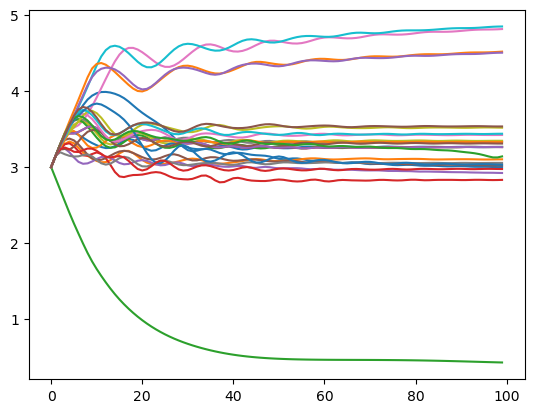

NPSF =  26


 88%|████████▊ | 194/220 [01:41<00:13,  1.91it/s]

In [ ]:
for batch_number in range(N_batch):
    t0 = time.time()
    raw, error_indices = extract_frames((batch_number+batch_offset)*Nframe+1, Nframe)
    x, y, z, rho, delta, index_frame = extract_positions((batch_number+batch_offset)*Nframe+1, Nframe, error_indices)
    raw = raw*sensitivity/(QE*EM)

    sigma = np.std(raw.flatten())
    background = np.mean(raw.flatten())

    nb = len(x)
    for k, ele in enumerate(x):
        if np.isnan(x[nb-1-k]) or np.isnan(y[nb-1-k]) or np.isnan(z[nb-1-k]) or np.isnan(rho[nb-1-k]) or np.isnan(delta[nb-1-k]):
            x = np.delete(x,nb-1-k,0)
            y = np.delete(y,nb-1-k,0)
            z = np.delete(z,nb-1-k,0)
            rho = np.delete(rho,nb-1-k,0)
            delta = np.delete(delta,nb-1-k,0)
            index_frame = np.delete(index_frame,nb-1-k,0)
    
    NPSF = len(x)

    single_psf = extract_raw_xy(raw[0], x[index_frame==0], y[index_frame==0])
    for i in range(1,Nframe):
        single_psf = np.concatenate((single_psf, extract_raw_xy(raw[i], x[index_frame==i], y[index_frame==i])))

    single_psf = single_psf[:,::-1]

    x_start = torch.tensor([0. for k in range(len(x))], requires_grad=False, device=device)
    y_start = torch.tensor([0. for k in range(len(x))], requires_grad=False, device=device)

    z_exp =  torch.tensor([3. for k in range(len(x))], requires_grad=False, device=device) 

    rho_exp = torch.tensor(rho, requires_grad=False, device=device)
    delta_exp = torch.tensor(delta, requires_grad=False, device=device)

    d_ = -torch.tensor([d[1] for k in range(len(x))], requires_grad=False, device=device)
    second_plane = torch.tensor([d[1]-d[0], 0, d[1]-d[2]])
    polar_projections = torch.tensor(np.array([0, 45, 0]))

    N=torch.tensor(80, device=device)
    l_pixel=torch.tensor(16, device=device)
    NA=torch.tensor(1.4, device=device)
    mag=torch.tensor(100, device=device)
    lambd=torch.tensor(638, device=device)
    f_tube=torch.tensor(200, device=device)
    MAG=torch.tensor(200/150, device=device)
    xx, yy, th1, phi, [Ex0, Ex1, Ex2], [Ey0, Ey1, Ey2], r, r_cut, k_, f_o = vectorial_BFP_perfect_focus(N, NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, device=device)

    if batch_number==0:
        phase_mask = torch.stack([torch.ones((N,N), device=device), torch.ones((N,N), device=device), torch.ones((N,N), device=device)])
        zernike_base = generate_zernike_base(r_cut=r_cut, N=N, zernike_order=4, device=device)
        zernike_coefs_x = torch.zeros((3,15), device=device)
        zernike_coefs_y = torch.zeros((3,15), device=device)
    
    noisy_psf = torch.tensor([single_psf[k] for k in range(len(x))], device=device)

    u, v, M = compute_M(xp=x_start, yp=y_start, zp=z_exp, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, phase_maskx=phase_mask, phase_masky=phase_mask, zernike_base=zernike_base, zernike_coefs_x=zernike_coefs_x, zernike_coefs_y=zernike_coefs_x,
                        second_plane=second_plane, polar_projections=polar_projections, N=N, l_pixel=l_pixel
                    , NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device, polar_offset=0., polar_offset2=0.)
    h = PSF(rho=torch.tensor(np.array([45. for k in range(NPSF)]), device=device), eta=torch.tensor([45. for k in range(NPSF)], device=device), delta=torch.tensor([100. for k in range(NPSF)], device=device), M=M, N_photons=torch.tensor([1000. for k in range(NPSF)], device=device))
    
    dim_simu = int(h.shape[-1]//2)

    ### first SGD on pos
    Nstart = torch.tensor([3000 for i in range(NPSF)], requires_grad=False, device=device)
    eta_rd = torch.tensor([45. for k in range(NPSF)], requires_grad=False, device=device)
    delta_rd = torch.tensor([150. for k in range(NPSF)], requires_grad=False, device=device)

    params = torch.cat((x_start, y_start, z_exp, Nstart/1000))
    params.requires_grad=True

    optimizer = torch.optim.Adam([params], lr=0.2)  # Learning rate = 0.012

    num_epochs_max = 100
    loss_ = []
    z__ = []
    for i in tqdm(range(num_epochs_max)):
        optimizer.zero_grad()  # Reset gradients
        loss = loss_pos(params[0:NPSF], params[NPSF:2*NPSF], params[2*NPSF:3*NPSF], rho_exp
                            , eta_rd, delta_exp, params[3*NPSF:4*NPSF]*1000, noisy_psf, second_plane, background, sigma, dim_simu) 
        loss_.append(loss.cpu().detach().numpy())
        z__.append(params[2*NPSF:3*NPSF].cpu().detach().numpy())
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
    ax = plt.plot(loss_)
    plt.ylim((np.min(np.array(loss_)), np.max(np.array(loss_))))
    plt.show()
    ax = plt.plot(z__)
    plt.show()
    del(ax, loss_, z__)

    x_found = params[0:NPSF].detach()
    y_found = params[NPSF:2*NPSF].detach()
    z_found = params[2*NPSF:3*NPSF].detach()
    N_found = params[3*NPSF:4*NPSF].detach()*1000
    del(params, loss)
    print('NPSF = ', NPSF)

    ### SGD 2 on orientation

    u, v, M = compute_M(xp=x_found, yp=y_found, zp=z_found, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, phase_maskx=phase_mask, phase_masky=phase_mask, zernike_base=zernike_base, zernike_coefs_x=zernike_coefs_x, zernike_coefs_y=zernike_coefs_x,
                        second_plane=second_plane, polar_projections=polar_projections, N=N, l_pixel=l_pixel
                    , NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device, polar_offset=20., polar_offset2=20.)
    
    eta_rd = torch.tensor([90. for k in range(NPSF)], requires_grad=False, device=device)
    offset_proj=20.
    #params = torch.cat((rho_exp, eta_rd, delta_exp, N_found/1000))
    #params = torch.cat((eta_rd, eta_rd, eta_rd, N_found/1000))
    params = torch.cat((eta_rd, eta_rd, eta_rd, N_found/1000))
    params.requires_grad=True

    # Use Stochastic Gradient Descent (SGD) to optimize params
    optimizer = torch.optim.Adam([params], lr=0.7)  # Learning rate = 0.01

    num_epochs_max = 220
    loss_ = []
    eta_ = []
    pol=[]
    for i in tqdm(range(num_epochs_max)):
        optimizer.zero_grad()  # Reset gradients
        #loss = loss_angle(M.detach(), params[:NPSF], params[1*NPSF:2*NPSF], params[2*NPSF:3*NPSF], 1000*params[3*NPSF:4*NPSF], noisy_psf, background, sigma, dim_simu)
        loss = loss_angle_with_M(27., 27., params[:NPSF], params[1*NPSF:2*NPSF], params[2*NPSF:3*NPSF], 1000*params[3*NPSF:4*NPSF], noisy_psf, background, sigma, dim_simu)
        loss_.append(loss.cpu().detach().numpy())
        eta_.append(params[1*NPSF:2*NPSF].cpu().detach().numpy())
        #pol.append(params[-2:].cpu().detach().numpy())
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
    fig, ax = plt.subplots(2)
    ax[0].plot(loss_) 
    ax[0].set_ylim((np.min(np.array(loss_)), np.max(np.array(loss_))))
    ax[1].plot(eta_)
    plt.show()
    del(fig, ax)

    rho_found=params[0:NPSF].detach()%180
    eta_found=params[1*NPSF:2*NPSF].detach()%180
    delta_found=params[2*NPSF:3*NPSF].detach()
    N_found2 = 1000*params[3*NPSF:4*NPSF].detach()
    offset_proj_found = 27.
    offset_proj_found2 = 27.
    del(params, loss, eta_, loss_)
    u, v, M = compute_M(xp=x_found, yp=y_found, zp=z_found, d=d_, x=xx, y=yy, th1=th1, phi=phi, Ex0=Ex0, Ex1=Ex1, Ex2=Ex2
                    , Ey0=Ey0, Ey1=Ey1, Ey2=Ey2, r=r, r_cut=r_cut, k=k_, f_o=f_o, phase_maskx=phase_mask, phase_masky=phase_mask, zernike_base=zernike_base, zernike_coefs_x=zernike_coefs_x, zernike_coefs_y=zernike_coefs_x,
                        second_plane=second_plane, polar_projections=polar_projections, N=N, l_pixel=l_pixel
                    , NA=NA, mag=mag, lambd=lambd, f_tube=f_tube, MAG=MAG, device=device, polar_offset=offset_proj_found, polar_offset2=offset_proj_found2)
    score = score_eval(M.detach().cpu(), rho_found.cpu(), eta_found.cpu(), delta_found.cpu(), N_found2.cpu(), noisy_psf.cpu(), background, sigma, dim_simu)
    x_ = (x/0.120).astype(int)*0.12 + x_found.cpu().detach().numpy()
    y_ = (y/0.120).astype(int)*0.12 + y_found.cpu().detach().numpy()
    np.savez_compressed('D:/AMAURY/experimental_processed/these_4polar_MFM/anneLise1/'+str(int(batch_number)+1+batch_offset)+'.npz', frame = index_frame, x=x_, y=y_, z=1000*z_found.cpu().detach().numpy(), N_photons=N_found2.cpu().detach().numpy(), offset_proj=offset_proj_found.cpu().detach().numpy(), offset_proj2=offset_proj_found2.cpu().detach().numpy(), rho=rho_found.cpu().detach().numpy(), eta=eta_found.cpu().detach().numpy(), delta=delta_found.cpu().detach().numpy(), score=score, x_start=x, y_start=y, z_start=z, rho_start=rho, delta_start=delta)
